<table style="width: 100%">
    <tr style="background: #ffffff">
        <td style="padding-top:25px;width: 180px"><img src="https://mci.edu/templates/mci/images/logo.svg" alt="Logo"></td>
        <td style="width: 100%">
            <div style="text-align:right; width: 100%; text-align:right"><font style="font-size:38px"><b>Grundlagen Programmierung</b></font></div>
            <div style="padding-top:0px; width: 100%; text-align:right"><font size="4"><b>WS 2023</b></font></div>
        </td>
    </tr>
</table>

---

# 6 Daten

Im folgenden Notebook sollen Sie ein ein Energiemanagementsystem für ein Gebäude mit PV-Anlage und Elektrofahrzeug entwickeln, welches das Elektrofahrzeug mit möglichst mit lokal erzeugtem Strom lädt. Die Aufgaben sollen Ihnen Routine darin vermitteln Aufgabenstellung zu interpretieren und in Code umzusetzen. Zudem arbeiten wir mit Daten in Matrizen, Tabellen und fertigen eigene Plots an.  

In [403]:
# Zunächst müssen wir einige Pakte importieren, welche uns bei unseren Aufgaben untersützen

# Numpy erweitert das Konzept der Listen auf Mathematische Matrizen
import numpy as np

# Datetime erleichtert das Arbeiten mit Zeiten
import datetime

# Matplotlib is ein Paket zum Erstellen von Plots
import matplotlib as mpl
import matplotlib.pyplot as plt

# Pandas ermöglicht das Arbeiten mit Tabellarischen Daten
import pandas as pd

Zunächst legen wir einen Tag an. Der Numpy array `timestamps` enthält nur einen Eintrag für jede Stunde des Tages als Datum (schön formatierte Unix-time). `steps` hingegen enthält genau die Stunde als Integer.

In [404]:

# Set the simulation parameters
start_time = pd.Timestamp("2023-07-17 00:00:00")
end_time = pd.Timestamp("2023-07-18 00:00:00")
num_periods = int((end_time - start_time) / pd.Timedelta(minutes=60))
steps =  list(range(num_periods))
# Create the timestamp array
timestamps = np.arange(start_time, end_time, np.timedelta64(60, "m"))
timestamps[0:5]

array(['2023-07-17T00:00:00.000000', '2023-07-17T01:00:00.000000',
       '2023-07-17T02:00:00.000000', '2023-07-17T03:00:00.000000',
       '2023-07-17T04:00:00.000000'], dtype='datetime64[us]')

✍️ **Aufgabe**

Zeigen Sie sich die ersten 10 Werte von `steps` an

In [405]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }

steps[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Als nächstes simulieren wir die Daten des Gebäudes und Plotten diese. Wir beginnen mit dem Strombedarf:

Text(0, 0.5, 'Strombedarf in kWh')

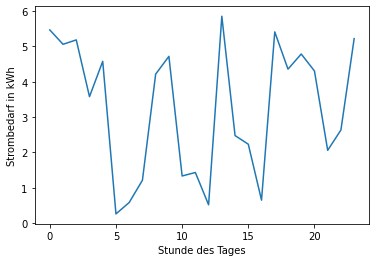

In [406]:
# Simulate electricity consumption (kWh)
consumption_kWh = np.random.uniform(0, 6, num_periods)


# Plottet die Daten
plt.plot(steps, consumption_kWh) # Der erste übergebene Array ist die X-, der zweite die Y-Achse

# Integriert eine Bezeichnung der x-Achse
plt.xlabel("Stunde des Tages")

# Integriert eine Bezeichnung der y-Achse
plt.ylabel("Strombedarf in kWh")

Als nächstes simulieren wir die Erzeugung der PV-Anlage:

In [407]:
pv_generation_kWh = np.zeros(len(timestamps))

pv_generation_kWh[7:19] = 3
pv_generation_kWh[8:18] = 5
pv_generation_kWh[10:16] = 6
pv_generation_kWh[12:14] = 6.5

✍️ **Aufgabe**

Erstellen Sie einen Plot, der die PV-Erzeugung visualisiert.

Text(0, 0.5, 'PV-Erzeugung in kWh')

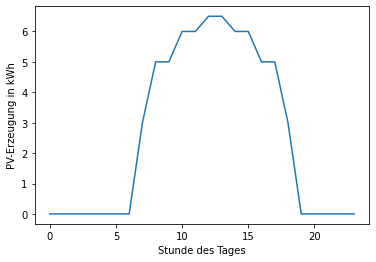

In [408]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }

# Plottet die Daten
plt.plot(steps, pv_generation_kWh)

# Integriert eine Bezeichnung der x-Achse
plt.xlabel("Stunde des Tages")

# Integriert eine Bezeichnung der y-Achse
plt.ylabel("PV-Erzeugung in kWh")

Zuletzt bereiten wir Daten für das Elektrofahrzeug (Battery Electric Vehicle / BEV) vor. `bev_connection` speichert, ob ein Elektrofahrzeug gerade mit der Ladestation verbunden ist. In `bev_soc_kWh` wird der aktuelle Füllstand der Batterie (State of Charge / SoC) gespeichert.

Wir nehmen an, dass das Fahrzeug um 13 Uhr eingesteckt wird und zu diesem Zeitpunkt mit 15 kWh geladen ist. Die Batteriegröße `bev_max_soc_kWh` beträgt 75 kWh.

Text(0, 0.5, 'Anwesenheit des Elektrofahrzeuges')

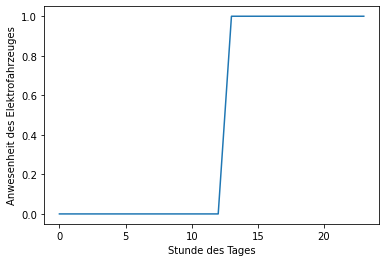

In [409]:
# Lege zunächst einen Array mit 24 Nullen an
bev_connection = np.zeros(len(timestamps))
# Fülle alle Werte ab dem 13. mit 1 (=BEV ist verbunden)
bev_connection[13:] = 1

# Lege zunächst einen Array mit 24 Nullen an
bev_soc_kWh = np.zeros(len(timestamps))
# Zu Beginn ist das Fahrzeug mit 15 kWh geladen. Alle Werte dahinter bleiben zunächst mit 0 befüllt, da wir diese noch nicht kennen.
bev_soc_kWh[13] = 15

# Maximaler SoC des Fahrzeugs
bev_max_soc_kWh = 75

# Plottet die Daten
plt.plot(steps, bev_connection)

# Integriert eine Bezeichnung der x-Achse
plt.xlabel("Stunde des Tages")

# Integriert eine Bezeichnung der y-Achse
plt.ylabel("Anwesenheit des Elektrofahrzeuges")

✍️ **Aufgabe**

Schreiben Sie eine Funktion, die für einen Zeitpunkt zurück gibt, ob gerade geladen wird oder nicht (`True` (es wird geladen) oder `False`).

Geladen werden kann nur, wenn das BEV gerade verbunden ist (`bev_connection == True`). Das Elektrofahrzeug lädt immer, wenn der SoC (`soc`) unter 10 kWh ist oder sobald mehr PV-Strom (`pv_generation_kWh`) erzeugt wird als das Gebäude verbraucht (`consumption_kWh`).

In [410]:
def charge_bev(bev_connection, soc, pv_generation_kWh, consumption_kWh):
    # Fügen Sie hier Ihren Code ein

SyntaxError: unexpected EOF while parsing (<ipython-input-410-9cadab1a8507>, line 2)

In [ ]:
# Testen der Funktion: Sollte True ausgeben
charge_bev(bev_connection = True, soc = 50, pv_generation_kWh = 20, consumption_kWh = 10)

True

In [ ]:
# Testen der Funktion: Sollte False ausgeben
charge_bev(bev_connection = True, soc = 50, pv_generation_kWh = 5, consumption_kWh = 10)

False

In [ ]:
# Testen der Funktion: Sollte True ausgeben
charge_bev(bev_connection = True, soc = 5, pv_generation_kWh = 5, consumption_kWh = 10)

True

In [ ]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }
 
def charge_bev(bev_connection, soc, pv_generation_kWh, consumption_kWh):
    charge  = False

    if bev_connection == False:
        return False
    elif soc < 10 or pv_generation_kWh > consumption_kWh:
        return True
    else:
        return False

✍️ **Aufgabe**

Schreiben Sie eine Funktion, die die Ladeleistung des Fahrzeuges in kW als `float` zurück gibt. Dabei soll folgendes gelten: Die Ladeleistung ist 0 kW, wenn nicht geladen wird. Bei einem Ladestand (SoC) unter 10 kWh wird immer mit der maximal möglichen Ladeleistung und 11 kW geladen. In allen anderen Fällen wird maximal mit der Überschussleistung der PV-Anlage geladen werden. 
Hierzu müssen Sie den Gebäudestrombedarf von der Erzeugung abziehen. Beachten Sie, dass wir die Erzeugung und den Gebäudestrombedarf als Energie und nicht als Leistung gegeben haben. Achten Sie zudem darauf, dass sie die Batterie des Fahrzeuges nicht überladen können.

In [ ]:
def charge_bev_speed(charge, soc, max_soc, pv_generation_kWh, consumption_kWh):
    # Fügen Sie hier Ihren Code ein

SyntaxError: unexpected EOF while parsing (<ipython-input-401-3b8dfbf7c90d>, line 2)

In [ ]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }
# Da wird in einem Raster von 1h Arbeiten, können wir direkt von kW ind kWh umrechnen, indem wir wir Werte mit 1 (h) multiplizieren


def charge_bev_speed(charge, soc, max_soc, pv_generation_kWh, consumption_kWh):
    capacity_left = max_soc - soc
    #print(capacity_left)
    if charge == False:
        return 0
    elif soc < 10:
        return 11
    else:     
        return max(0, min(capacity_left, pv_generation_kWh - consumption_kWh))


In [ ]:
# Testen der Funktion
charge_bev_speed(charge = True, soc = 70 , max_soc = 75, pv_generation_kWh = 20 ,consumption_kWh = 10)

5

Nun, da Ihre Funktionen funktionieren, können wir diese in ein rechtes System einbauen. Um das Zusammenspiel zu evaluieren, werden wir aber zunächst einen Tag simulieren. Im echten System würden die Funktionen z.B. in einer `while`-Schleife Werden und immer wieder aufgerufen werden. Da wir nur einen Tag simulieren, nutzen wir die `for`-Schleife durch unseren simulierten Tag. 
Über `index, time in enumerate(timestamps)` können wir in die Schleife über `index` den jeweils n-ten-Eintrag in jeder Liste abgreifen. Da alle Liste genau 24 Einträge lang sind, erhalten wir so immer wie Einträge, die zusammen gehören. 

In [ ]:
charge = []
charging_speed_kW = []

for index, time in enumerate(timestamps):
    print("Jetzt ist die {}. Stunde. Genauer gesagt {}".format(index, timestamps[index]))

    # Rufen Sie charge_bev() auf, um zu überprüfen, ob gerade geladen werden sollte und fügen Sei das Ergebnis an die Liste charge an

    # Rufen Sie current_charging_speed_kWh() auf, um die aktuelle Ladegeschwindigkeit zu bestimmen.
    # Beachten Sie dabei, dass Sie dazu den aktuellen SoC berücksichtigen müssen, der in der Zeile index-1 steht!
    
    # fügen Sei das Ergebnis an die Liste charging_speed_kW an

    # Updaten sie die Liste bev_soc_kWh an der aktuellen Stelle. 
    # Beachten Sie dabei, dass Sie dazu den aktuellen SoC aus der Zeile davor mit der charging_speed_kW (*1h) addieren müssen

Jetzt ist die 0. Stunde. Genauer gesagt 2023-07-17T00:00:00.000000
Jetzt ist die 1. Stunde. Genauer gesagt 2023-07-17T01:00:00.000000
Jetzt ist die 2. Stunde. Genauer gesagt 2023-07-17T02:00:00.000000
Jetzt ist die 3. Stunde. Genauer gesagt 2023-07-17T03:00:00.000000
Jetzt ist die 4. Stunde. Genauer gesagt 2023-07-17T04:00:00.000000
Jetzt ist die 5. Stunde. Genauer gesagt 2023-07-17T05:00:00.000000
Jetzt ist die 6. Stunde. Genauer gesagt 2023-07-17T06:00:00.000000
Jetzt ist die 7. Stunde. Genauer gesagt 2023-07-17T07:00:00.000000
Jetzt ist die 8. Stunde. Genauer gesagt 2023-07-17T08:00:00.000000
Jetzt ist die 9. Stunde. Genauer gesagt 2023-07-17T09:00:00.000000
Jetzt ist die 10. Stunde. Genauer gesagt 2023-07-17T10:00:00.000000
Jetzt ist die 11. Stunde. Genauer gesagt 2023-07-17T11:00:00.000000
Jetzt ist die 12. Stunde. Genauer gesagt 2023-07-17T12:00:00.000000
Jetzt ist die 13. Stunde. Genauer gesagt 2023-07-17T13:00:00.000000
Jetzt ist die 14. Stunde. Genauer gesagt 2023-07-17T14:00:

In [411]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }

charge = []
charging_speed_kW = []

for index, time in enumerate(timestamps):
    #print(index)
    charge.append(charge_bev(bev_connection[index], bev_soc_kWh[index],pv_generation_kWh[index], consumption_kWh[index]))
    current_charging_speed_kW = charge_bev_speed(charge[index],bev_soc_kWh[index-1], bev_max_soc_kWh,pv_generation_kWh[index], consumption_kWh[index])
    charging_speed_kW.append(current_charging_speed_kW)
    bev_soc_kWh[index] = bev_soc_kWh[index-1] + current_charging_speed_kW
#charge
#charging_speed_kWh
#bev_soc_kWh

Herzlichen Glückwunsch. Sie haben nun erfolgreich simuliert, wie das Fahrzeug geladen werden würde. Lassen Sie uns die verschiedenen Lastgänge in einer Grafik zusammenfassen:

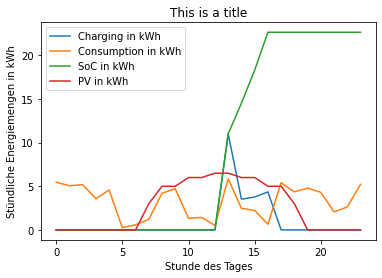

In [414]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plottet die Daten
plt.plot(steps, charging_speed_kW)
plt.plot(steps, consumption_kWh)
plt.plot(steps, bev_soc_kWh)
plt.plot(steps, pv_generation_kWh)
# Integriert einen Titel
plt.title("This is a title")

# Integriert eine Bezeichnung der x-Achse
plt.xlabel("Stunde des Tages")

# Integriert eine Bezeichnung der y-Achse
plt.ylabel("Stündliche Energiemengen in kWh")

# Integriert die Legende
plt.legend(['Charging in kWh','Consumption in kWh', 'SoC in kWh', 'PV in kWh'])


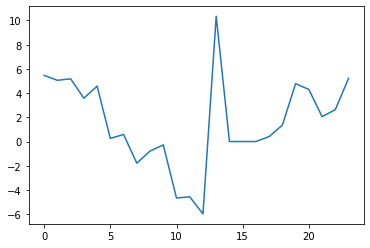

In [418]:
last_an_hausanschluss = consumption_kWh + charging_speed_kW - pv_generation_kWh
last_an_hausanschluss
plt.plot(steps, last_an_hausanschluss)

✍️ **Aufgabe**

Bestimmen Sie wie viel Energie das Gebäude an diesem Tag vom Netz bezogen hat, wie viel ein eingespeist hat und was die maximale Durchschnittliche last am hausanschluss an diesem Tag war.

Anschaulich müssen Sie die Zeitreihe `last_an_hausanschluss` in ihre positiven und negativen Bestandteile zerlegen und dann die Fläche unter den verbleibenden Kurven summieren. 

Berechnen Sie auch die Stromkosten für diesen Tag. Rechen Sie mit einer Einspeisevergütung von 0.20 Cent / kWh und einen Strompreis von 30 Cent /kWh.

In [ ]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }


In [415]:
import pandas as pd
optimized_charging = {    "consumption_kWh" : consumption_kWh,
                "charging_speed_kWh" : charging_speed_kW,
                "bev_soc_kWh" : bev_soc_kWh,
                "pv_generation_kWh" : pv_generation_kWh,
                "timestamps" : timestamps 

}
dataframe = pd.DataFrame(optimized_charging)
dataframe.head()

,consumption_kWh,charging_speed_kWh,bev_soc_kWh,pv_generation_kWh,timestamps
0,5.464522,0.0,0.0,0.0,2023-07-17 00:00:00
1,5.057976,0.0,0.0,0.0,2023-07-17 01:00:00
2,5.182561,0.0,0.0,0.0,2023-07-17 02:00:00
3,3.576919,0.0,0.0,0.0,2023-07-17 03:00:00
4,4.576128,0.0,0.0,0.0,2023-07-17 04:00:00


In [358]:
dataframe.to_csv("results_optimized_charging.csv")

In [359]:
dataframe.describe()

,consumption_kWh,charging_speed_kWh,bev_soc_kWh,pv_generation_kWh
count,24.000000,24.000000,24.000000,24.000000
mean,3.368432,0.809881,8.082008,2.666667
std,1.887802,2.415602,9.220116,2.869126
min,0.184349,0.000000,0.000000,0.000000
25%,1.702510,0.000000,0.000000,0.000000
50%,3.656753,0.000000,0.000000,1.500000
75%,4.837697,0.000000,19.437136,5.250000
max,5.958227,11.000000,19.437136,7.000000
